<span style="font-family:Calibri; font-size:3em;">Handwritten Digits Classifier</span>

<span style="font-family:Calibri; font-size:2em;">A guided project with UCI data set</span>

![Image](https://cdn-images-1.medium.com/max/2400/1*LmxW8FDfXZJl5yvESvjP7Q.jpeg)

## Introduction

In this project, we'll:
* explore why image classification is a hard task
* observe the limitations of traditional machine learning models for image classification
* train, test, and improve a few different deep neural networks for image classification

The `sklearn` library has built-in function that returns the exact copy of [hand-written digits dataset](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) from UCI.

In [1]:
from sklearn.datasets import load_digits
digits = load_digits(as_frame=True)
print(digits.data.shape)

(1797, 64)


In [2]:
digits.frame.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


The data set has **1797** images are represented as a row of pixel values. Since each row contain **64** values our images have **8x8** resolution.

Let's display some of them using `matplotlib`.

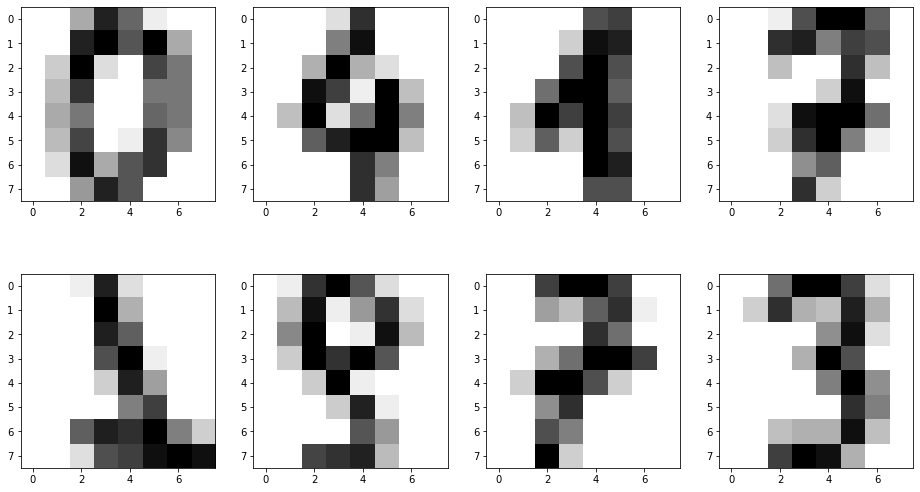

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

fix, axs = plt.subplots(2, 4, figsize=(16,9))
digits_df = digits.data
bias = 0

for row in range(2):
    for col in range(4):
        #Calculate index for each image
        #It would be 1100 for second bottom image for exaple 
        index = col * 100 + bias
        image = digits_df.iloc[index].values.reshape(8,8)
        axs[row, col].imshow(image, cmap='gray_r')
        
    bias = 1000

## KNN classifier

Due to there is no linearity between image's pixels and an actiual digit we'll use the k-nearest neighbors algorithm here. The `KNeighborsClassifier` to be precise.

Let's define a few functions and run them with **k=5** and **folds=4**.

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def train_test(train_set, test_set, k, how='train'):
    #trains and tests k-nearest neighbors models with different k
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_set.iloc[:, :-1], train_set['target'])
    
    #uses train or test sets in predict() depending on how
    if how == 'train':
        prediction = knn.predict(train_set.iloc[:, :-1])
        accuracy = accuracy_score(train_set['target'], prediction)
        return accuracy
    
    elif how == 'test':
        prediction = knn.predict(test_set.iloc[:, :-1])
        accuracy = accuracy_score(test_set['target'], prediction)
        return accuracy
    
def cross_validate(data, k, how='train'):
    #performs 4-fold cross validation using train() and test()
    #returns overall accuracy
    
    kf = KFold(n_splits=4,
              shuffle=True,
              random_state=0)
    
    accuracies = []
    
    for train_index, test_index in kf.split(data):
        
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]

        accuracy = train_test(train_set, test_set, k, how)
        accuracies.append(accuracy)
        
    return np.mean(accuracies)

cross_validate(digits.frame, 5)

0.990725350762988

Now let's iterate number of neigbors and build a plot for computed accuracies.

In [5]:
knn_accuracies = pd.DataFrame(index=range(1,36), columns=['train', 'test'])

methods = ['train', 'test']

#Iterate over both methods and 25 neigbors numbers
for how in methods:
    for k in range(1,36):
        accuracy = cross_validate(digits.frame, k, how)
        knn_accuracies.loc[k, how] = accuracy
    
knn_accuracies.tail(10)

,train,test
26,0.968466,0.966616
27,0.967724,0.964946
28,0.966796,0.964389
29,0.967539,0.963832
30,0.966982,0.964947
31,0.966055,0.964947
32,0.965127,0.963276
33,0.964942,0.962163
34,0.9642,0.961605
35,0.963829,0.959379


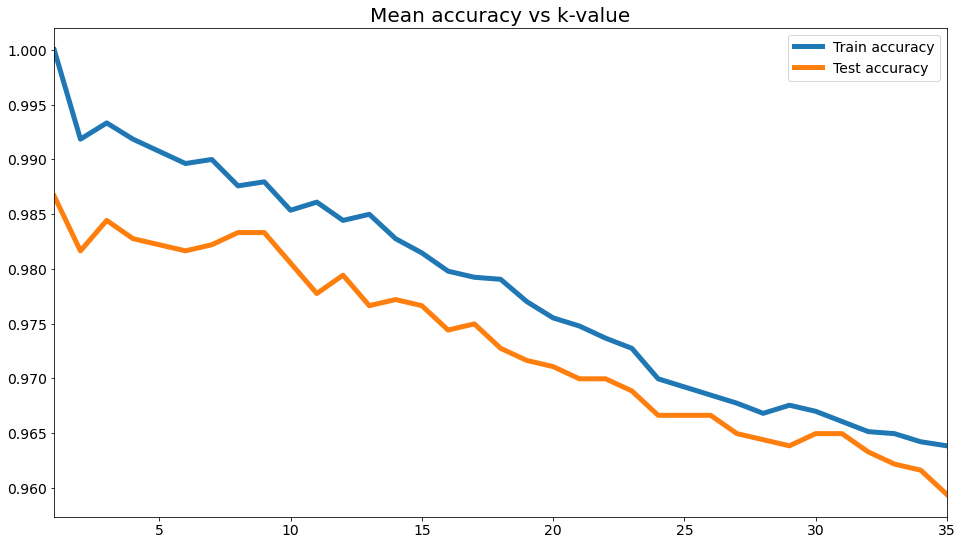

In [6]:
fig, ax = plt.subplots(figsize=(16,9))

for col in knn_accuracies.columns:
    ax.plot(knn_accuracies[col],
           lw=5)

#decorations
ax.set_xlim(1, 35)
ax.set_title('Mean accuracy vs k-value', fontsize=20)
ax.tick_params(labelsize=14)
ax.legend(['Train accuracy', 'Test accuracy'],
         fontsize=14)

It seems the best result's achived with **k=1**, **0.986** on test set and **1** on train. Both accurasies are extreamly high due to we use in-build dataset. Also increasing k-value doesn't make our predictions more accurate.

Also we can observe the difference between train and test accuracies which is signal of overfitting. But increasing k-value decreases this difference. For example, with **k=25** we'got **0.969** and	**0.966** for train and test sets respectively.

But we'll stick to the our best result - **k=1** and **0.986**. Let's try to improve this result with neural network.

## MLP classifier

There are a few downsides to using k-nearest neighbors:
* high memory usage (for each new unseen observation, many comparisons need to be made to seen observations)
* no model representation to debug and explore

Considering this we'll try a neural network with a single hidden layer but with different number of neurons. We'll keep using cross validation with 4 folds at this try aswell.

In [132]:
from sklearn.neural_network import MLPClassifier

def mlp_cross_val(data, n):
    #performs 4-fold cross validation using MLPClassifier
    #returns overall accuracies
    
    kf = KFold(n_splits=4,
              shuffle=True,
              random_state=0)
    
    train_accuracies = []
    test_accuracies = []
    
    for train_index, test_index in kf.split(data):
        
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]
        
        mlp_class = MLPClassifier(hidden_layer_sizes=(n,),
                                  solver='sgd',
                                  max_iter=750,
                                  learning_rate_init=0.01,
                                  random_state=0)
        
        mlp_class.fit(train_set.iloc[:, :-1], train_set['target'])
        
        #Use train or test sets in score() depending on how
        train_accuracy = mlp_class.score(train_set.iloc[:, :-1],
                                       train_set['target'])

        test_accuracy = mlp_class.score(test_set.iloc[:, :-1],
                                       test_set['target'])

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
    return np.mean(train_accuracies), np.mean(test_accuracies)

Now we've got `mlp_cross_val()` func, let's iterate through different neurons number.

In [133]:
neurons = np.around(np.geomspace(8, 256, num=6)).astype(int) #also index

neurons_accuracies = pd.DataFrame(index=neurons, columns=['train', 'test'])

#Iterate over 6 neurons numbers
for neuron in neurons:
    train_acc, test_acc = mlp_cross_val(digits.frame, neuron)
    neurons_accuracies.loc[neuron, 'train'] = train_acc
    neurons_accuracies.loc[neuron, 'test'] = test_acc

neurons_accuracies

,train,test
8,0.673716,0.628839
16,0.966794,0.907622
32,1.0,0.958264
64,1.0,0.973846
128,1.0,0.979412
256,1.0,0.978855


And now we'll build a plot.

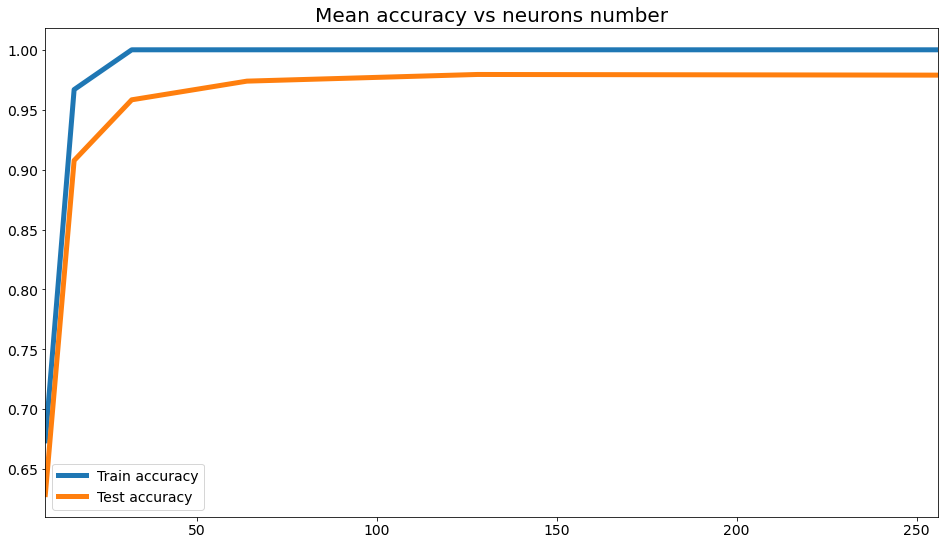

In [134]:
fig, ax = plt.subplots(figsize=(16,9))

for col in neurons_accuracies.columns:
    ax.plot(neurons_accuracies[col],
           lw=5)

#decorations
ax.set_xlim(8, 256)
ax.set_title('Mean accuracy vs neurons number', fontsize=20)
ax.tick_params(labelsize=14)
ax.legend(['Train accuracy', 'Test accuracy'],
         fontsize=14)

Our model's accuracy hit **1** pretty fast on train set while it's a bit lower on test set. But train accuracy is increasing with number of neurons in the hidden layer. It reaches **0.978** with **256** neurons but it's still worse than knn classification gave us. And there is still overfitting.

Would it be more effective to use more layers? Let's find out!

## Multilayer network

We'll start with one additional layer and use the same neurons numbers. Let's update `mlp_cross_val()` for that.

In [135]:
def mlp_cross_val(data, n, layers=1):
    #performs 4-fold cross validation using MLPClassifier
    #returns overall accuracy
    
    kf = KFold(n_splits=4,
              shuffle=True,
              random_state=0)
    
    train_accuracies = []
    test_accuracies = []
    
    #Create a tuple with n nerouns in layers
    hidden_layers = tuple([n for layer in range(layers)])
    
    for train_index, test_index in kf.split(data):
        
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]
        
        mlp_class = MLPClassifier(hidden_layer_sizes=hidden_layers,
                                  solver='sgd',
                                  max_iter=750,
                                  learning_rate_init=0.01,
                                  random_state=0)
        
        mlp_class.fit(train_set.iloc[:, :-1], train_set['target'])
        
        #Use train or test sets in score() depending on how
        train_accuracy = mlp_class.score(train_set.iloc[:, :-1],
                                       train_set['target'])

        test_accuracy = mlp_class.score(test_set.iloc[:, :-1],
                                       test_set['target'])

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
    return np.mean(train_accuracies), np.mean(test_accuracies)

Now we'll use our function with different hyperparameters. And for that we'll create another func!

The `accurasies_plot_nn()` function will train NN with defined layers parameters and add resulting mean accuracy with NN hyperparameters to the `neurons_accuracies`. It will also build a "Mean accuracy vs neurons number" plot. 

In [136]:
def accurasies_plot_nn(data, layer, neurons):
    #Iterate over both methods and neurons
    for neuron in neurons:
        new_row = [layer, neuron]
        accuracies = mlp_cross_val(data, neuron, layer)
        new_row.extend(list(accuracies))
        neurons_accuracies.loc[len(neurons_accuracies)] = new_row
    
    #Build plot
    fig, ax = plt.subplots(figsize=(16,9))
    columns = ['train', 'test']
    layer_accuracies = neurons_accuracies[neurons_accuracies['layers'] == layer]
    
    for col in columns:
        ax.plot(layer_accuracies['neurons'], 
                layer_accuracies[col],
               lw=5)

    #decorations
    ax.set_xlim(8, 256)
    ax.set_title('Mean accuracy vs neurons number', fontsize=20)
    ax.tick_params(labelsize=14)
    ax.legend(['Train accuracy', 'Test accuracy'],
             fontsize=14,
             loc='lower right')

Also let's prepare `neurons_accuracies` dataframe.

In [137]:
#Modify accuracies df
neurons_accuracies.reset_index(inplace=True)
neurons_accuracies.rename(columns={'index': 'neurons'}, inplace=True)
neurons_accuracies.insert(0, "layers", 1)

neurons_accuracies.tail(6)

,layers,neurons,train,test
0,1,8,0.673716,0.628839
1,1,16,0.966794,0.907622
2,1,32,1.0,0.958264
3,1,64,1.0,0.973846
4,1,128,1.0,0.979412
5,1,256,1.0,0.978855


### Two hidden layers

Two hidden layers NN, here we go! 

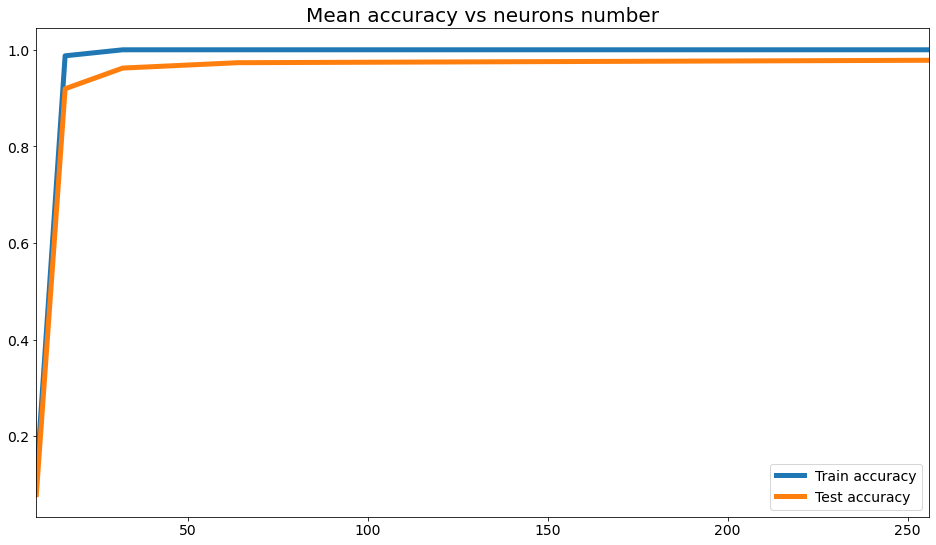

In [138]:
accurasies_plot_nn(digits.frame, 2, neurons)

In [139]:
neurons_accuracies.tail(6)

,layers,neurons,train,test
6,2.0,8.0,0.107957,0.079018
7,2.0,16.0,0.987574,0.919296
8,2.0,32.0,1.0,0.96216
9,2.0,64.0,1.0,0.973293
10,2.0,128.0,1.0,0.974963
11,2.0,256.0,1.0,0.978301


Our best shot brought us **0.978** accuracy with **256** neurons and it's the worst result so far for the NN.

### Three hidden layers

Let's try 3 hidden layers this time.

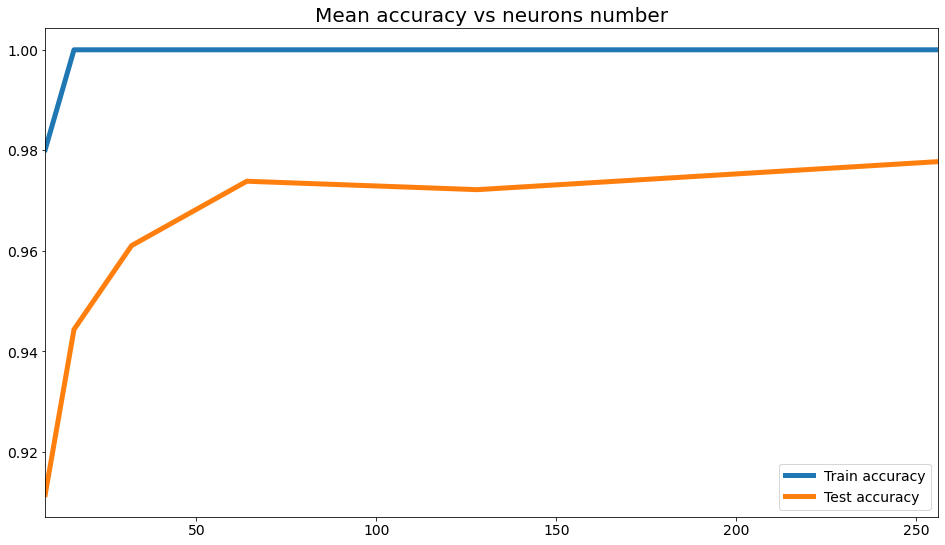

In [140]:
accurasies_plot_nn(digits.frame, 3, neurons)

In [141]:
neurons_accuracies.tail(6)

,layers,neurons,train,test
12,3.0,8.0,0.980155,0.911513
13,3.0,16.0,1.0,0.944362
14,3.0,32.0,1.0,0.961047
15,3.0,64.0,1.0,0.973851
16,3.0,128.0,1.0,0.972174
17,3.0,256.0,1.0,0.977747


Using one additional layer doesn't improve accuracy at all and tends to overfitting. We should try different approach.

## Activation functions

MLPClassifier uses [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) by default. We can change it to [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) and [hyperbolic tan function](https://en.wikipedia.org/wiki/Hyperbolic_functions). There is also identity function but we leave it.

We'll test both function with one hidden layer. Let's update our functions.

In [160]:
def mlp_cross_val(data, n, layers=1, func='relu'):
    #performs 4-fold cross validation using MLPClassifier
    #returns overall accuracy
    
    kf = KFold(n_splits=4,
              shuffle=True,
              random_state=0)
    
    train_accuracies = []
    test_accuracies = []
    
    #Create a tuple with n nerouns in layers
    hidden_layers = tuple([n for layer in range(layers)])
    
    for train_index, test_index in kf.split(data):
        
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]
        
        mlp_class = MLPClassifier(hidden_layer_sizes=hidden_layers,
                                  max_iter=750,
                                  solver='sgd',
                                  learning_rate_init=0.01,
                                  random_state=0,
                                  activation=func)
        
        mlp_class.fit(train_set.iloc[:, :-1], train_set['target'])
        
        #Use train or test sets in score() depending on how
        train_accuracy = mlp_class.score(train_set.iloc[:, :-1],
                                       train_set['target'])

        test_accuracy = mlp_class.score(test_set.iloc[:, :-1],
                                       test_set['target'])

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
    return np.mean(train_accuracies), np.mean(test_accuracies)

def accurasies_nn(data, layers, neurons, func='relu'):
    #Iterate over both methods and neurons and layers
    for layer in layers:
        for neuron in neurons:
            new_row = [layer, neuron]
            accuracies = mlp_cross_val(data, neuron, layer, func)
            new_row.extend(list(accuracies))
            new_row.append(func)
            neurons_accuracies.loc[len(neurons_accuracies)] = new_row      
            


def nn_plot(func):    
    #Build plots
    fig, axs = plt.subplots(3, 1, figsize=(16,18))
    plt.suptitle('Mean accuracies {} function'.format(func), size=26)
    columns = ['train', 'test']
    
    for i in range(3):
        #Filter our df
        mask = (neurons_accuracies['layers'] == (i + 1)) & (neurons_accuracies['func'] == func)
        layer_accuracies = neurons_accuracies[mask]
        
        for col in columns:
            axs[i].plot(layer_accuracies['neurons'], 
                       layer_accuracies[col],
                       lw=4)

            #decorations
            axs[i].set_xlim(8, 256)
            axs[i].set_title('{} hidden layers'.format(i + 1), fontsize=20)
            axs[i].tick_params(labelsize=14)
            axs[i].legend(['Train accuracy', 'Test accuracy'],
                         fontsize=14,
                         loc='lower right')

### Sigmoid func

In [161]:
neurons_accuracies['func'] = 'relu'

function = ['logistic', 'tanh']
layers = [1, 2 ,3]

accurasies_nn(digits.frame, layers, neurons, function[0])
neurons_accuracies.tail(18)

C:\Users\3axap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (750) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\3axap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (750) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\3axap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (750) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\3axap\AppData

,layers,neurons,train,test,func
108,1.0,8.0,0.99054,0.923768,logistic
109,1.0,16.0,0.996847,0.95548,logistic
110,1.0,32.0,1.0,0.976076,logistic
111,1.0,64.0,0.999814,0.975517,logistic
112,1.0,128.0,1.0,0.981084,logistic
113,1.0,256.0,1.0,0.982195,logistic
114,2.0,8.0,0.985903,0.922096,logistic
115,2.0,16.0,0.99796,0.9566,logistic
116,2.0,32.0,0.999258,0.963826,logistic
117,2.0,64.0,0.999444,0.972176,logistic


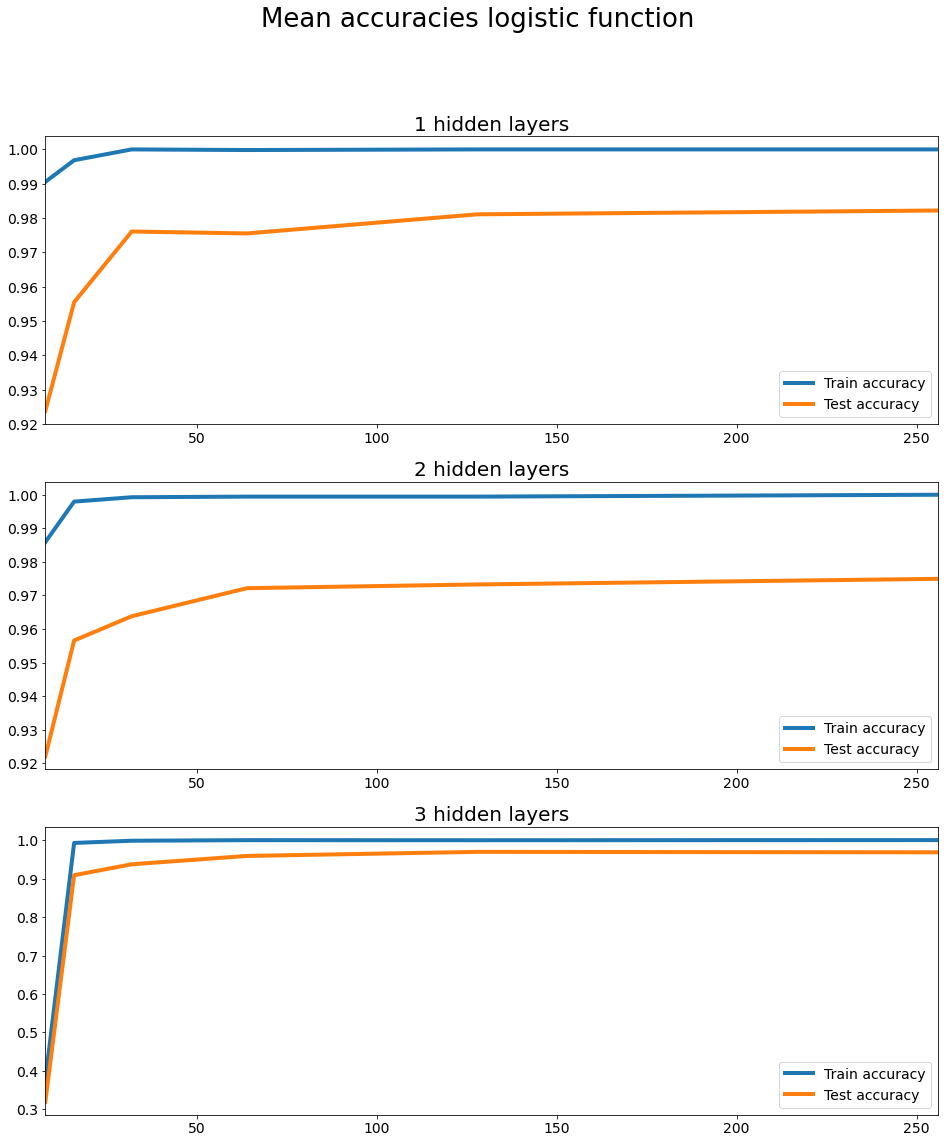

In [162]:
nn_plot(function[0])

### Tanh func

In [ ]:
accurasies_nn(digits.frame, layers, neurons, function[1])
neurons_accuracies.tail(18)

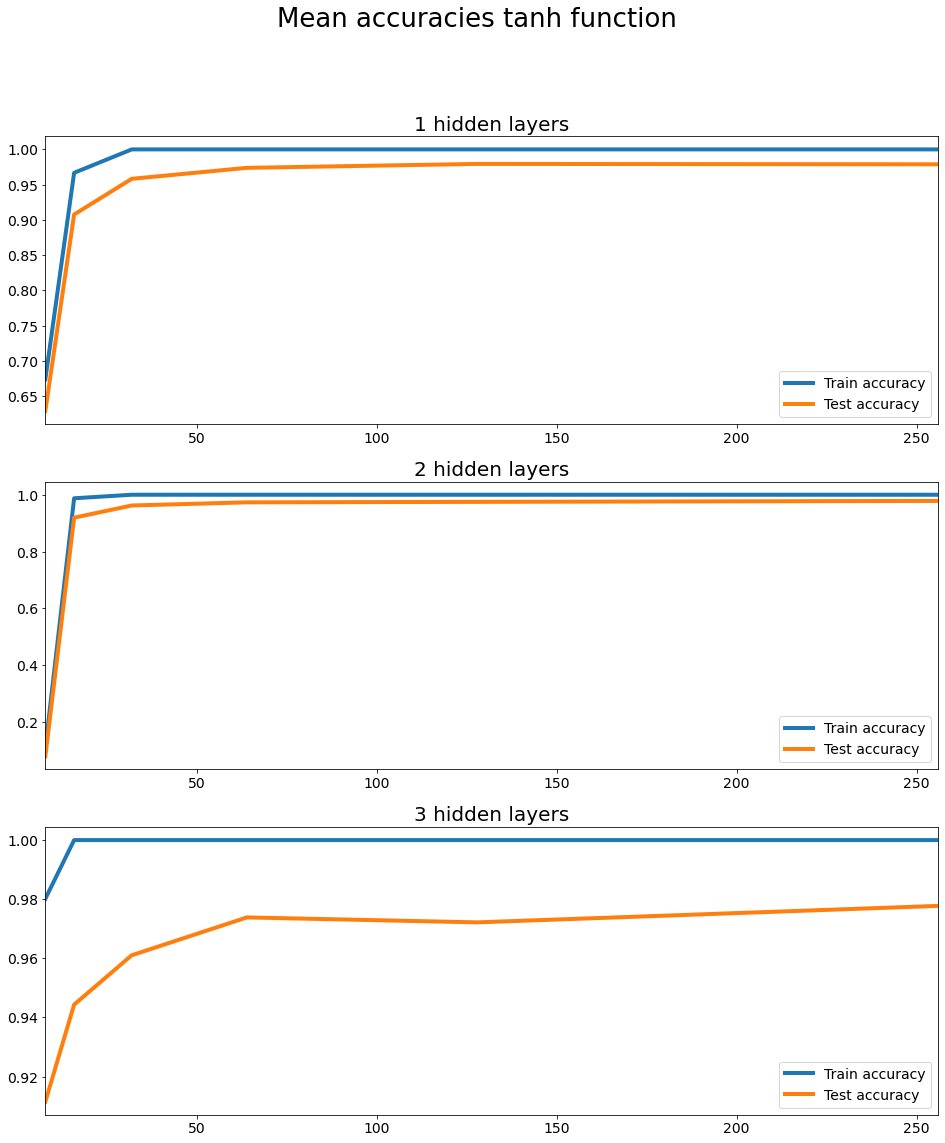

In [156]:
nn_plot(function[1])

Okay, we've tried all three activation functions so far and even beaten the KNN results. We've got **0.978** accuracy with **tanh** func and **2** hidden layers **256** neurons each.

But all our models seem to be too **"perfect"**, to be **overfitted**. Regardless of hyperparameters we're still getting train accuracies close to or even **equal 1**, while test accuracies are quite lower. This gap decreases with increasing complexity of NN (especially tanh) but it doesn't solve our problem.

Our best results are down below. We'll keep them here and try to improve our model further.

In [157]:
neurons_accuracies.groupby(['func', 'layers'])['test'].max()

func      layers
logistic  1.0       0.979412
          2.0       0.978301
          3.0       0.977747
relu      1.0       0.979412
          2.0       0.978301
          3.0       0.977747
tanh      1.0       0.979412
          2.0       0.978301
          3.0       0.977747
Name: test, dtype: float64

In [158]:
neurons_accuracies

,layers,neurons,train,test,func
0,1.0,8.0,0.673716,0.628839,relu
1,1.0,16.0,0.966794,0.907622,relu
2,1.0,32.0,1.0,0.958264,relu
3,1.0,64.0,1.0,0.973846,relu
4,1.0,128.0,1.0,0.979412,relu
...,...,...,...,...,...
85,3.0,16.0,1.0,0.944362,tanh
86,3.0,32.0,1.0,0.961047,tanh
87,3.0,64.0,1.0,0.973851,tanh
88,3.0,128.0,1.0,0.972174,tanh


## L2 regularization

Now we'll use our ultimate weapon - [L2 regularization](https://towardsdatascience.com/intuitions-on-l1-and-l2-regularisation-235f2db4c261).

MLPClassifier has special parameter `alpha` for that which we'll be manually changing. Let's first update the `mlp_cross_val()`.

In [149]:
def mlp_cross_val(data, n=8, layers=1, func='relu', alpha=0.0001):
    #performs 4-fold cross validation using MLPClassifier
    #returns overall accuracy
    
    kf = KFold(n_splits=4,
              shuffle=True,
              random_state=0)
    
    train_accuracies = []
    test_accuracies = []
    
    #Create a tuple with n nerouns in layers
    hidden_layers = tuple([n for layer in range(layers)])
    
    for train_index, test_index in kf.split(data):
        
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]
        
        mlp_class = MLPClassifier(hidden_layer_sizes=hidden_layers,
                                  max_iter=750,
                                  learning_rate_init=0.01,
                                 random_state=2,
                                 activation=func,
                                 alpha=alpha)
        
        mlp_class.fit(train_set.iloc[:, :-1], train_set['target'])
        
        #Use train or test sets in score() depending on how
        train_accuracy = mlp_class.score(train_set.iloc[:, :-1],
                                       train_set['target'])

        test_accuracy = mlp_class.score(test_set.iloc[:, :-1],
                                       test_set['target'])

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
        return np.mean(train_accuracies), np.mean(test_accuracies)

We'll iterate alpha with the default parameters and rough alpha iteration.

In [37]:
alphas = np.linspace(0.001, 1, 10)

for alpha in alphas:
        x = mlp_cross_val(digits.frame, alpha=alpha)
        print('train {:.3f} - test {:.3f} with alpha {}'.format(x[0], x[1], alpha))

train 0.869 - test 0.809 with alpha 0.001
train 0.877 - test 0.816 with alpha 0.112
train 0.856 - test 0.811 with alpha 0.223
train 0.964 - test 0.907 with alpha 0.334
train 0.947 - test 0.909 with alpha 0.445
train 0.938 - test 0.884 with alpha 0.556
train 0.931 - test 0.871 with alpha 0.667
train 0.936 - test 0.896 with alpha 0.778
train 0.940 - test 0.893 with alpha 0.889
train 0.942 - test 0.889 with alpha 1.0


In [32]:
np.linspace(0.001, 1, 10)

array([0.001, 0.112, 0.223, 0.334, 0.445, 0.556, 0.667, 0.778, 0.889,
       1.   ])

Something interesting happens when alpha is bigger than **10**. Let's take a closer look at this interval. 

In [26]:
#Prepare alpha values and special df
alphas_2 = np.linspace(200, 300, 11)

alpha_df = pd.DataFrame({'layers': 1,
                         'alpha': alphas_2,
                         'train': np.nan,
                         'test': np.nan})

#Iterate through alpha values
for alpha in alphas_2:
    for how in methods:
        accuracy = mlp_cross_val(digits.frame, how=how, alpha=alpha)
        alpha_df.loc[alpha_df['alpha'] == alpha, how] = accuracy
        
alpha_df

,layers,alpha,train,test
0,1,200.0,0.882210,0.878139
1,1,210.0,0.875346,0.869238
2,1,220.0,0.862919,0.856990
3,1,230.0,0.853458,0.843081
4,1,240.0,0.853273,0.848088
5,1,250.0,0.841031,0.839738
6,1,260.0,0.838434,0.834175
7,1,270.0,0.830457,0.827503
8,1,280.0,0.823965,0.819713
9,1,290.0,0.817103,0.810804


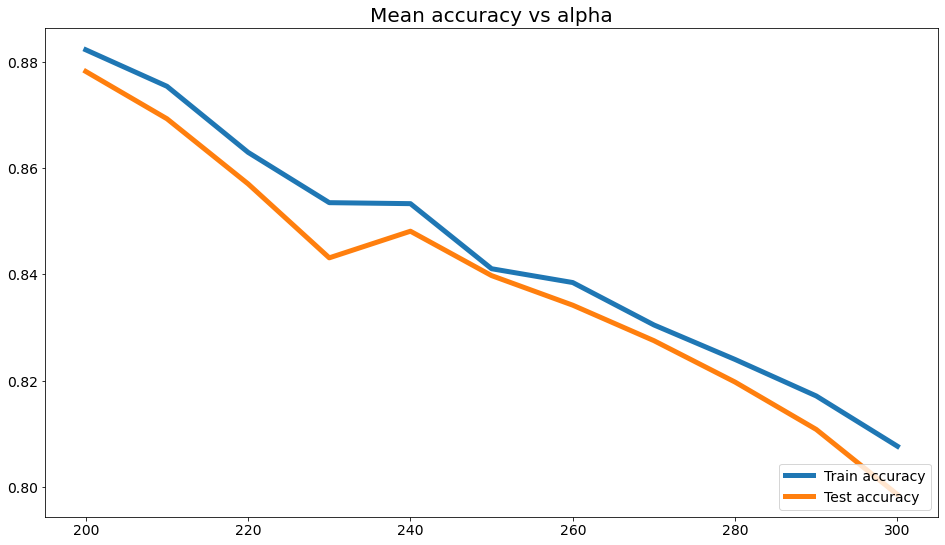

In [27]:
fig, ax = plt.subplots(figsize=(16,9))
columns = ['train', 'test']
    
for col in columns:
    ax.plot(alpha_df['alpha'], 
            alpha_df[col],
            lw=5)

#Decorations
#ax.set_xlim(20, 190)
ax.set_title('Mean accuracy vs alpha', fontsize=20)
ax.tick_params(labelsize=14)
ax.legend(['Train accuracy', 'Test accuracy'],
            fontsize=14,
            loc='lower right')

In [28]:
mlp_cross_val(digits.frame, layers=2, alpha=35)

0.9230189794223453